# Tutorial: Using `fastai.data` low-level APIs for Pets

> Using `DataSource`, `Pipeline`, `PipedList`, and `Transform`s to load the Pets dataset.

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

Let's see how to use `fastai.data` to process the Pets dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

First we grab the items and split indices:

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

## Using only `Transform`

We'll need this function to create consistently sized tensors from image files:

In [ ]:
def resized_image(fn, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

We need to create a `Transform` that converts from an index to our `x` and `y` for modeling.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        super().__init__()
        self.items,self.train_idx = items,train_idx
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)
        
    def encodes(self, i):
        o = self.items[i]
        return resized_image(o), self.o2i[self.labeller(o)]
    
    def decodes(self, o): return o[0],self.vocab[o[1]]
    def shows(self, o, ax=None): show_image(o[0], ax, title=o[1])

We can now create the `PetTfm`. We pass the training set indices to the constructor so it can create a vocab from only those items.

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets[0]
x.shape,y

(torch.Size([3, 128, 128]), 23)

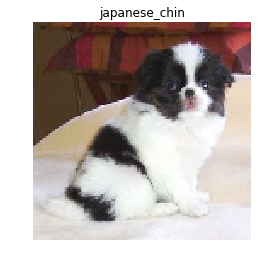

In [ ]:
pets.show((x,y))

## Using `Pipeline` to create Siamese model dataset

A *Siamese* model needs a dataset with two images as input, and a boolean output that is `True` if the two images are the "same" (e.g. are pictures of the same breed of pet). Custom structures like this are often easiest to create using `Pipeline`, which makes no assumptions about the structure of your input or output data.

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels = items,labels
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "Tuple of `i`th image and a random image from same or different class"
        item,lbl = self.items[i],self.labels[i]
        is_same = torch.rand(1).item()>0.5
        othercls = self.clsmap[lbl] if is_same else self.idxs
        otherit = random.choice(othercls)
        # check we didn't get same class coincidentally
        is_same = self.labels[otherit]==lbl
        return (item,self.items[otherit]),is_same
    
    def shows(self, o, ctx=None):
        (x1,x2),y = o
        show_image(torch.cat([x1,x2], dim=2), title=y, ctx=ctx)

In [ ]:
sp = SiamesePair(items, items.mapped(labeller))
resized_images = mapper(resized_image)
pipe = Pipeline([sp, lambda o: (resized_images(o[0]),o[1])])
pipe.setup()

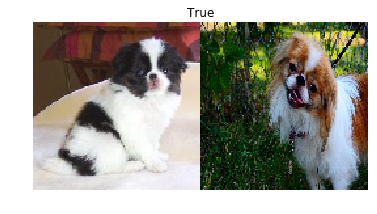

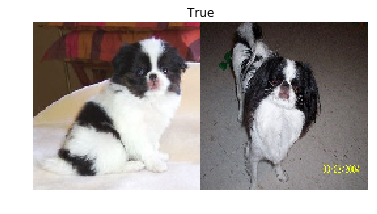

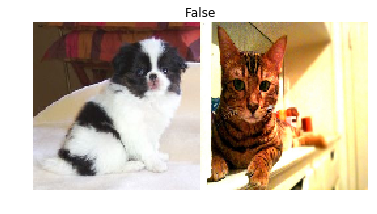

In [ ]:
for _ in range(3): pipe.show_at(0)

## Using `Pipelines`

`Pipeline` simply runs a sequence of transforms in order, and `Pipelines` applies a list of pipelines lazily to items of a collection, creating one output per pipeline. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.

In [ ]:
valid_labels = items[split_idx[0]].mapped(labeller)
vocab = uniqueify(valid_labels)

In [ ]:
c = Categorize(subset_idx=split_idx[0])
tfms = [[Imagify(), ImageResizer(128), ImageToByteTensor(), ByteToFloatTensor(with_lbl=False)],
        [labeller, c]]
pl = Pipelines.create(items, tfms)

In [ ]:
t = pl[0]

In [ ]:
x,y = pl.decode(t)
x.shape,y

(torch.Size([128, 128, 3]), 'japanese_chin')

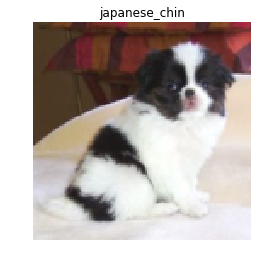

In [ ]:
pl.show(t)

## DataSource

In [ ]:
c = Categorize()
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()]
tfm = Pipelines([[Imagify()] + ds_img_tfms,
                 [labeller, c]])

pets = DataSource(items, tfm, filts=split_idx)

To access an element we need to specify the subset (either with `train`/`valid` or with `subset(i)`):

In [ ]:
x,y = pets.subset(1)[0]
x.shape,y

(torch.Size([3, 128, 128]), 12)

...or equivalently:

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index to `decode_at`.

In [ ]:
xy = pets.valid.decode((x,y))
xy[1]

'american_bulldog'

In [ ]:
xy2 = pets.valid.decode_at(0)
test_eq(type(xy2[1]), str)
test_eq(xy2, xy)

We're now ready to show our items.

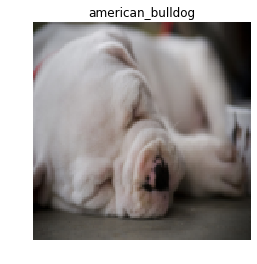

In [ ]:
pets.show((x,y))

We can use this to feed a `DataLoader` and view a batch. It's faster to convert to float on CPU, so we'll do it as a DataLoader transform, after CUDA.

In [ ]:
dl_tfms = [Cuda(), ByteToFloatTensor()]
trn_dl = TfmDataLoader(pets.train, dl_tfms, 9)
b = trn_dl.one_batch()

test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor')

In [ ]:
bd = trn_dl.decode(b)

test_eq(len(bd[0]), 9)
test_eq(bd[0][0].shape, (128,128,3))

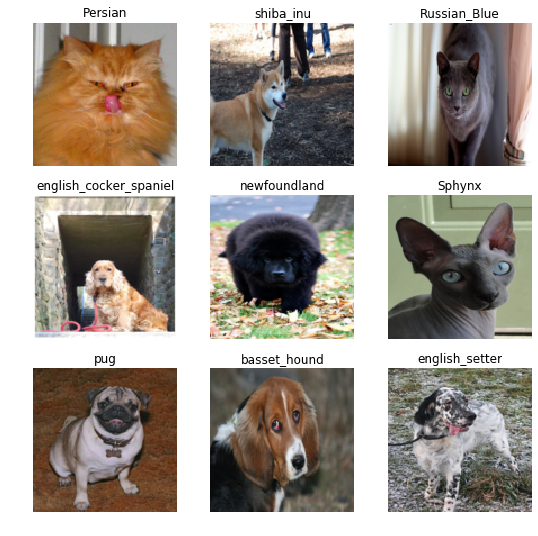

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
trn_dl.show_batch(ctxs=axs.flatten())

## Segmentation

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
tfm = Pipelines([[Imagify()] + ds_img_tfms,
                 [cv_label, Imagify(cmap='tab20', alpha=0.5)] + ds_img_tfms])

camvid = DataSource(cv_items, tfm, filts=cv_split)

In [ ]:
trn_dl = TfmDataLoader(camvid.train, dl_tfms, 4)
b = trn_dl.one_batch()
bd = trn_dl.decode(b)

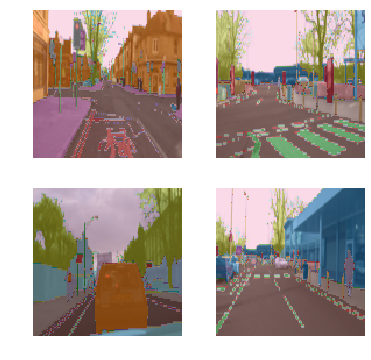

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

## fin -